In [ ]:
#Data Generation

In [1]:

class StatsGenerator:

    def __init__(self, year, weeks=None):

        import nflgame

        self.current_year, self.current_week = nflgame.live.current_year_and_week()
        self.year = year
        self.current_year_marker = (self.year == self.current_year)

        if weeks is None:
            if self.year == self.current_year:
                weeks = range(1, self.current_week+1)
            else:
                weeks = range(1, 18)

        self.weeks = weeks

        self.functions = {
            'result':
                {'func': self.game_result_stats, 'file_name': '0_game_result_stats'},
            'schedule':
                {'func': self.schedule_stats, 'file_name': '1_schedule_stats'},
            'record':
                {'func': self.record_stats, 'file_name': '2_record_stats'},
            'matchup':
                {'func': self.matchup_stats, 'file_name': '3_matchup_stats'},
            'point_differential':
                {'func': self.point_differential_stats, 'file_name': '4_point_differential_stats'},
            'turnover':
                {'func': self.turnover_stats, 'file_name': '5_turnover_stats'},
            'third_down_pct':
                {'func': self.third_down_pct_stats, 'file_name': '6_third_down_stats'}
        }

    def generate_stats(self):
        import os
        import glob
        import csv
        import utils
        import pandas as pd

        for week in self.weeks:

            print '\rGenerating stats for week {}'.format(week)

            directory = './data/game_data/{}/{}/'.format(self.year, week)
            if not os.path.exists(directory):
                os.makedirs(directory)

            games = utils.get_week_schedule(self.year, week)

            for f in self.functions.keys():
                func_dict = self.functions[f]
                func = func_dict['func']
                file_name = '{}.csv'.format(func_dict['file_name'])
                path = directory + file_name

                update_results_tag = (f == 'result' and
                                      self.current_year_marker and
                                      self.current_week == week)

                if not os.path.exists(path) or update_results_tag:
                    data = func(games)
                    with open(path, 'wb') as csv_file:
                        writer = csv.writer(csv_file)
                        for line in data:
                            writer.writerow(line)

            # Combining all files together
            all_files = glob.glob(directory + '*.csv')

            df = pd.concat((pd.read_csv(f) for f in all_files),
                           axis=1, sort=False)
            df.to_csv('./data/game_data/{}/week_{}_database.csv'.format(year, week), index=False)

        self.combine_yearly_data()

    def combine_yearly_data(self):

        import glob
        import pandas as pd

        directory = './data/game_data/{}/'.format(year)
        all_files = glob.glob('{}*.csv'.format(directory))

        if len(all_files) == 17:
            print 'Combining yearly data'

            df = pd.concat((pd.read_csv(f) for f in all_files),
                           axis=0, sort=False)
            df.to_csv('./data/game_data/{}_database.csv'.format(year), index=False)

        else:
            print 'Cannot combine, not enough week files for entire year'

    def schedule_stats(self, games):
        """
        Generates basic stats about the game which don't change throughout the season
        :return:
        """
        import utils

        header = ['gamekey', 'year', 'week',
                  'away', 'away_prev_wpct', 'away_prev_a_wpct',
                  'home', 'home_prev_wpct', 'home_prev_h_wpct',
                  'div_flag']

        data = []
        data.append(header)

        print 'Generating schedule stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            game['home_prev_wpct'] = utils.team_prev_season_win_pct(home, year, prev_seasons=1)
            game['home_prev_h_wpct'] = utils.team_prev_season_win_pct(home, year, prev_seasons=1,
                                                                      type='home')
            game['away_prev_wpct'] = utils.team_prev_season_win_pct(away, year, prev_seasons=1)
            game['away_prev_a_wpct'] = utils.team_prev_season_win_pct(away, year, prev_seasons=1,
                                                                      type='away')
            game['div_flag'] = utils.divisional_flag(home, away)

            row = [game[h] for h in header]
            data.append(row)

        return data

    def game_result_stats(self, games):
        """
        Generates stats for the result for each game if known, converting it into terms of a home win/loss,
        tie or unknown result (i.e game hasn't been played)
        :param games:
        :return:
        """
        import nflgame

        header = ['result']
        data = []
        data.append(header)

        print 'Generating game result stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            result_dictionary = {home: 'win', home + '/' + away: 'tie', away: 'loss'}

            try:
                winner = nflgame.one(year, week, home, away).winner
                result = result_dictionary[winner]
            except (AttributeError, KeyError):
                result = 'UNK'

            game['result'] = result

            row = [game[h] for h in header]
            data.append(row)

        return data

    def record_stats(self, games):
        """
        Generates stats regarding the home and away team's season records so far
        :param games:
        :return:
        """
        import utils

        header = ['away_record', 'away_wpct', 'away_a_wpct',
                  'home_record', 'home_wpct', 'home_h_wpct']
        data = []
        data.append(header)

        print 'Generating current record stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            # home record
            hw, hl, ht = utils.team_record(home, year, week - 1)
            game['home_record'] = '{}-{}-{}'.format(hw, hl, ht)

            # away record
            aw, al, at = utils.team_record(away, year, week - 1)
            game['away_record'] = '{}-{}-{}'.format(aw, al, at)

            game['home_wpct'] = utils.team_season_win_pct(home, year, week - 1)
            game['home_h_wpct'] = utils.team_season_win_pct(home, year, week - 1, type='home')

            game['away_wpct'] = utils.team_season_win_pct(away, year, week - 1)
            game['away_a_wpct'] = utils.team_season_win_pct(away, year, week - 1, type='away')

            row = [game[h] for h in header]
            data.append(row)

        return data

    def matchup_stats(self, games):
        """
        Generates stats of all the home vs away games in season so far and previous 2 seasons
        :param games:
        :return:
        """
        import utils

        header = ['matchup_weight']

        data_dict = {}
        data = []
        data.append(header)

        print 'Generating matchup stats'

        for game in games:
            data_dict['matchup_weight'] = utils.matchup_weight(game)
            row = [data_dict[h] for h in header]
            data.append(row)

        return data

    def point_differential_stats(self, games):
        """ Generates stats of each team's point differential over the previous season, seeason so far and last
        3 and 5 games
        :param games:
        :return:
        """
        import utils

        data_dict = {}
        data = []
        header = ['home_season_pt_dif', 'home_3game_pt_dif',
                  'home_5game_pt_dif', 'home_prev_season_pt_dif',
                  'away_season_pt_dif', 'away_3game_pt_dif',
                  'away_5game_pt_dif', 'away_prev_season_pt_dif']
        data.append(header)

        print 'Generating point differential stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            home_season_pt_dif, home_3game_pt_dif, home_5game_pt_dif = \
                utils.team_pt_dif_per_n_games(home, year, week)
            data_dict['home_season_pt_dif'] = home_season_pt_dif
            data_dict['home_3game_pt_dif'] = home_3game_pt_dif
            data_dict['home_5game_pt_dif'] = home_5game_pt_dif
            data_dict['home_prev_season_pt_dif'] = utils.team_pt_dif_per_game_season(home, year - 1)

            away_season_pt_dif, away_3game_pt_dif, away_5game_pt_dif = \
                utils.team_pt_dif_per_n_games(away, year, week)
            data_dict['away_season_pt_dif'] = away_season_pt_dif
            data_dict['away_3game_pt_dif'] = away_3game_pt_dif
            data_dict['away_5game_pt_dif'] = away_5game_pt_dif
            data_dict['away_prev_season_pt_dif'] = utils.team_pt_dif_per_game_season(away, year - 1)

            row = [data_dict[h] for h in header]
            data.append(row)

        return data

    def turnover_stats(self, games):
        """
        Generates turnover stats for each team so far that season, last season and last 2 and 5 games
        :param games:
        :return:
        """
        import utils

        data_dictionary = {}
        data = []
        header = [
            'home_season_turnovers',
            'home_3game_turnovers',
            'home_5game_turnovers',
            'home_prev_season_turnovers',
            'away_season_turnovers',
            'away_3game_turnovers',
            'away_5game_turnovers',
            'away_prev_season_turnovers',
            'home_season_turnover_dif',
            'home_3game_turnover_dif',
            'home_5game_turnover_dif',
            'home_prev_season_turnover_dif',
            'away_season_turnover_dif',
            'away_3game_turnover_dif',
            'away_5game_turnover_dif',
            'away_prev_season_turnover_dif',
        ]
        data.append(header)

        print 'Generating turnover stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            # Previous season stats
            home_prev_season_turnover_dict = utils.turnovers_per_game_season(home, year-1)
            away_prev_season_turnover_dict = utils.turnovers_per_game_season(away, year-1)
            data_dictionary['home_prev_season_turnovers'] = \
                home_prev_season_turnover_dict['turnovers_per_game']
            data_dictionary['home_prev_season_turnover_dif'] = \
                home_prev_season_turnover_dict['turnover_dif_per_game']
            data_dictionary['away_prev_season_turnovers'] = \
                away_prev_season_turnover_dict['turnovers_per_game']
            data_dictionary['away_prev_season_turnover_dif'] = \
                away_prev_season_turnover_dict['turnover_dif_per_game']

            for team, label in zip([home, away], ['home', 'away']):
                turnover_dict = utils.turnovers_per_game(team, year, week)
                data_dictionary[label + '_season_turnovers'] = \
                    turnover_dict['season_turnovers_per_game']
                data_dictionary[label + '_3game_turnovers'] = \
                    turnover_dict['3game_turnovers_per_game']
                data_dictionary[label + '_5game_turnovers'] = \
                    turnover_dict['5game_turnovers_per_game']
                data_dictionary[label + '_season_turnover_dif'] = \
                    turnover_dict['season_turnover_dif_per_game']
                data_dictionary[label + '_3game_turnover_dif'] = \
                    turnover_dict['3game_turnover_dif_per_game']
                data_dictionary[label + '_5game_turnover_dif'] = \
                    turnover_dict['5game_turnover_dif_per_game']

            row = [data_dictionary[h] for h in header]
            data.append(row)

        return data

    def third_down_pct_stats(self, games):
        """
        Generates turnover stats for each team
        :param games:
        :return:
        """
        import utils

        data_dictionary = {}
        headers = [
            'home_season_3down_pct',
            'home_3game_3down_pct',
            'home_5game_3down_pct',
            'away_season_3down_pct',
            'away_3game_3down_pct',
            'away_5game_3down_pct'
        ]
        data = []
        data.append(headers)

        print 'Generating third down stats'

        for game in games:
            # for convenience
            year, week = game['year'], game['week']
            home, away = game['home'], game['away']

            for team, label in zip([home, away], ['home', 'away']):
                tdp_dict = utils.third_down_pct_per_game(team, year, week)
                data_dictionary[label + '_season_3down_pct'] = \
                    tdp_dict['season_3down_pct_per_game']
                data_dictionary[label + '_3game_3down_pct'] = \
                    tdp_dict['3game_3down_pct_per_game']
                data_dictionary[label + '_5game_3down_pct'] = \
                    tdp_dict['5game_3down_pct_per_game']

            row = [data_dictionary[h] for h in headers]
            data.append(row)

        return data


if __name__ == '__main__':

    # weeks, year = [5, 6], 2017
    # stats = StatsGenerator(year)
    # stats.generate_stats()

    import nflgame

    years = range(2010, 2019)
    # years = [2018]

    for year in years:

        print year
        stats = StatsGenerator(year)
        stats.generate_stats()


2010
Generating stats for week 1
Generating stats for week 2
Generating stats for week 3
Generating stats for week 4
Generating stats for week 5
Generating stats for week 6
Generating stats for week 7
Generating stats for week 8
Generating stats for week 9
Generating stats for week 10
Generating stats for week 11
Generating stats for week 12
Generating stats for week 13
Generating stats for week 14
Generating stats for week 15
Generating stats for week 16
Generating stats for week 17
Combining yearly data
2011
Generating stats for week 1
Generating stats for week 2
Generating stats for week 3
Generating stats for week 4
Generating stats for week 5
Generating stats for week 6
Generating stats for week 7
Generating stats for week 8
Generating stats for week 9
Generating stats for week 10
Generating stats for week 11
Generating stats for week 12
Generating stats for week 13
Generating stats for week 14
Generating stats for week 15
Generating stats for week 16
Generating stats for week 17


Generating game result stats
Generating matchup stats
Generating turnover stats
Generating stats for week 11
Generating point differential stats
Generating schedule stats
Generating third down stats
Generating current record stats
Generating game result stats
Generating matchup stats
Generating turnover stats
Generating stats for week 12
Generating point differential stats
Generating schedule stats
Generating third down stats
Generating current record stats
Generating game result stats
Generating matchup stats
Generating turnover stats
Generating stats for week 13
Generating point differential stats
Generating schedule stats
Generating third down stats
Generating current record stats
Generating game result stats
Generating matchup stats
Generating turnover stats
Generating stats for week 14
Generating point differential stats
Generating schedule stats
Generating third down stats
Generating current record stats
Generating game result stats
Generating matchup stats
Generating turnover st

KeyboardInterrupt: 

In [ ]:
#Feature Selection

In [2]:
import pandas as pd
import itertools

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)


def svc_param_selection(X, y, nfolds):
    from sklearn import svm

    GridSearchCV = sklearn.model_selection.GridSearchCV
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_


data_path = r'./data/game_data/'

# Evaluation set
# Training set
years = ['2010',
         '2011',
         '2012',
         '2013',
         '2014',
         '2015',
         '2016',
         '2017'
         ]

base_features = [
    'week',
    'home_wpct',
    'home_h_wpct',
    'home_prev_wpct',
    'away_wpct',
    'away_a_wpct',
    'away_prev_wpct',
    'matchup_weight',
]

additional_features = [
    'home_prev_h_wpct',
    'away_prev_a_wpct',
    'div_flag',
    'home_season_pt_dif',
    'home_3game_pt_dif',
    'home_5game_pt_dif',
    'home_prev_season_pt_dif',
    'away_season_pt_dif',
    'away_3game_pt_dif',
    'away_5game_pt_dif',
    'away_prev_season_pt_dif'
                 ]

all_files = [data_path + str(year) + '_database.csv' for year in years]
data_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

feature_sub_list = []
for r in range(6, len(additional_features)+1):
    [feature_sub_list.append(l) for l in list(itertools.combinations(additional_features, r))]

results = []
counter = 1
for f in feature_sub_list:

    additional_features = list(f)
    feature_list = base_features + additional_features

    if counter % 10 == 0:
        print '{}/{}'.format(counter, len(feature_sub_list)+1)
    counter += 1

    X = data_df[feature_list]
    Y = data_df['result']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.125, shuffle=False)

    svm = SVC()
    svm.fit(X_train, Y_train)
    train_accuracy = svm.score(X_train, Y_train)
    test_accuracy = svm.score(X_test, Y_test)

    results.append([train_accuracy, test_accuracy, additional_features])

df = pd.DataFrame(results, columns=['train_accuracy', 'test_accuracy', 'features'])

sorted_df = df.sort_values(by='test_accuracy', ascending=False)

# print sorted_df
print sorted_df.head(20).to_string()

# row = df.loc[df['test_accuracy'].idxmax()]
# print row['train_accuracy'], row['test_accuracy'],  row['features']


/home/shaswata/miniconda3/envs/py2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


10/1025
20/1025
30/1025
40/1025
50/1025
60/1025
70/1025
80/1025
90/1025
100/1025
110/1025
120/1025
130/1025
140/1025
150/1025
160/1025
170/1025
180/1025
190/1025
200/1025
210/1025
220/1025
230/1025
240/1025
250/1025
260/1025
270/1025
280/1025
290/1025
300/1025
310/1025
320/1025
330/1025
340/1025
350/1025
360/1025
370/1025
380/1025
390/1025
400/1025
410/1025
420/1025
430/1025
440/1025
450/1025
460/1025
470/1025
480/1025
490/1025
500/1025
510/1025
520/1025
530/1025
540/1025
550/1025
560/1025
570/1025
580/1025
590/1025
600/1025
610/1025
620/1025
630/1025
640/1025
650/1025
660/1025
670/1025
680/1025
690/1025
700/1025
710/1025
720/1025
730/1025
740/1025
750/1025
760/1025
770/1025
780/1025
790/1025
800/1025
810/1025
820/1025
830/1025
840/1025
850/1025
860/1025
870/1025
880/1025
890/1025
900/1025
910/1025
920/1025
930/1025
940/1025
950/1025
960/1025
970/1025
980/1025
990/1025
1000/1025
1010/1025
1020/1025
     train_accuracy  test_accuracy                                                      

In [ ]:
#model comparison

In [3]:
import utils
import nflgame
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing


pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999

data_path = r'./data/game_data/'

# Training set
years = ['2010', '2011', '2012', '2013', '2014', '2015']
all_files = [data_path + str(year) + '_database.csv' for year in years]
train_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
train_df = utils.scrub_data(train_df)

# Testing set
years = ['2016', '2017']
all_files = [data_path + str(year) + '_database.csv' for year in years]
test_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
test_df = utils.scrub_data(test_df)

# Feature scaling
features_to_scale = ['home_season_pt_dif',
         'home_3game_pt_dif',
         'home_5game_pt_dif',
         'home_prev_season_pt_dif',
         'away_season_pt_dif',
         'away_3game_pt_dif',
         'away_5game_pt_dif',
         'away_prev_season_pt_dif']

from sklearn.preprocessing import scale

train_df[features_to_scale] = scale(train_df[features_to_scale])
test_df[features_to_scale] = scale(test_df[features_to_scale])

feature_names = [
    'week',
    'home_wpct',
    'home_h_wpct',
    'home_prev_wpct',
    'home_prev_h_wpct',
    'away_wpct',
    'away_a_wpct',
    'away_prev_wpct',
    'away_prev_a_wpct',
    'div_flag',
    'matchup_weight',
    'home_season_pt_dif',
    'home_3game_pt_dif',
    'home_5game_pt_dif',
    'home_prev_season_pt_dif',
    'away_season_pt_dif',
    'away_3game_pt_dif',
    'away_5game_pt_dif',
    'away_prev_season_pt_dif'
                 ]

X_train = train_df[feature_names]
Y_train = train_df['result']

X_test = test_df[feature_names]
Y_test = test_df['result']

logreg = LogisticRegression(C=2)
logreg.fit(X_train, Y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
      .format(logreg.score(X_train, Y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
      .format(logreg.score(X_test, Y_test)))


def knn_param_selection(X, y, nfolds):
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier

    knn = KNeighborsClassifier()
    GridSearchCV = sklearn.model_selection.GridSearchCV
    param_grid = {'n_neighbors': [5, 6, 7, 8, 9, 10],
                  'leaf_size': [1, 2, 3, 5],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    grid_search = GridSearchCV(knn, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_


params = knn_param_selection(X_train, Y_train, 3)
print params
knn = KNeighborsClassifier(**params)
knn.fit(X_train, Y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
      .format(knn.score(X_train, Y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
      .format(knn.score(X_test, Y_test)))

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
      .format(lda.score(X_train, Y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
      .format(lda.score(X_test, Y_test)))

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
      .format(gnb.score(X_train, Y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
      .format(gnb.score(X_test, Y_test)))


def svc_param_selection(X, y, nfolds):
    from sklearn import svm
    import numpy as np

    GridSearchCV = sklearn.model_selection.GridSearchCV
    Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    # gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'rbf']
    param_grid = {'C': Cs, 'kernel': kernels}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_


# Learning
params = svc_param_selection(X_train, Y_train, 3)
print params
svm = SVC(**params)
# svm = SVC()
svm.fit(X_train, Y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
      .format(svm.score(X_train, Y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
      .format(svm.score(X_test, Y_test)))

/home/shaswata/miniconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.62
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 1, 'algorithm': 'auto'}
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.60
Accuracy of LDA classifier on training set: 0.65
Accuracy of LDA classifier on test set: 0.63
Accuracy of GNB classifier on training set: 0.63
Accuracy of GNB classifier on test set: 0.62
{'kernel': 'linear', 'C': 0.2}
Accuracy of SVM classifier on training set: 0.65
Accuracy of SVM classifier on test set: 0.61


In [ ]:
#model training

In [4]:
import utils
import nflgame
import sklearn
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import itertools

pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999

feature_names = [
    'week',
    'home_wpct',
    'home_h_wpct',
    'home_prev_wpct',
    'home_prev_h_wpct',
    'away_wpct',
    'away_a_wpct',
    'away_prev_wpct',
    'away_prev_a_wpct',
    'div_flag',
    'matchup_weight',
    'home_season_pt_dif',
    'home_3game_pt_dif',
    'home_5game_pt_dif',
    'home_prev_season_pt_dif',
    'away_season_pt_dif',
    'away_3game_pt_dif',
    'away_5game_pt_dif',
    'away_prev_season_pt_dif'
                 ]

years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

data_path = r'./data/game_data/'
all_files = [data_path + str(year) + '_database.csv' for year in years]
data_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Remove unknown results and ties from the data
data_df = utils.scrub_data(data_df)

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

features_to_scale = ['home_season_pt_dif',
                     'home_3game_pt_dif',
                     'home_5game_pt_dif',
                     'home_prev_season_pt_dif',
                     'away_season_pt_dif',
                     'away_3game_pt_dif',
                     'away_5game_pt_dif',
                     'away_prev_season_pt_dif']

data_df[features_to_scale] = scaler.fit_transform(data_df[features_to_scale])

X = data_df[feature_names]
Y = data_df['result']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=True)


def svc_param_selection(X, y, nfolds):
    from sklearn import svm

    GridSearchCV = sklearn.model_selection.GridSearchCV
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_


print '---------'
params = svc_param_selection(X_train, Y_train, 5)
svm = SVC(C=params['C'], gamma=params['gamma'])
trained_model = svm.fit(X_train, Y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
      .format(svm.score(X_train, Y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
      .format(svm.score(X_test, Y_test)))
y_pred = trained_model.predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)

# class_names = trained_model.classes_
class_names = sorted(trained_model.classes_)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=class_names,
                      title='Normalized confusion matrix')

plt.show()

---------
Accuracy of SVM classifier on training set: 0.66
Accuracy of SVM classifier on test set: 0.62
Confusion matrix, without normalization
[[155 291]
 [ 96 480]]
Normalized confusion matrix
[[0.35 0.65]
 [0.17 0.83]]


<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

In [ ]:
#predict

In [5]:
import utils
import nflgame
import sklearn
import numpy as np
from sklearn.svm import SVC
import os

import pandas as pd

pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999

data_path = r'./data/game_data/'

feature_names = [
    'week',
    'home_wpct',
    'home_h_wpct',
    'home_prev_wpct',
    'home_prev_h_wpct',
    'away_wpct',
    'away_a_wpct',
    'away_prev_wpct',
    'away_prev_a_wpct',
    # 'div_flag',
    'matchup_weight',
    'home_season_pt_dif',
    'home_3game_pt_dif',
    'home_5game_pt_dif',
    'home_prev_season_pt_dif',
    'away_season_pt_dif',
    'away_3game_pt_dif',
    'away_5game_pt_dif',
    'away_prev_season_pt_dif',
    'home_season_turnovers',
    'home_3game_turnovers',
    'home_5game_turnovers',
    'home_prev_season_turnovers',
    'home_season_turnover_dif',
    'home_3game_turnover_dif',
    'home_5game_turnover_dif',
    'home_prev_season_turnover_dif',
    'away_season_turnovers',
    'away_3game_turnovers',
    'away_5game_turnovers',
    'away_prev_season_turnovers',
    'away_season_turnover_dif',
    'away_3game_turnover_dif',
    'away_5game_turnover_dif',
    'away_prev_season_turnover_dif',
    'home_season_3down_pct',
    'home_3game_3down_pct',
    'home_5game_3down_pct',
    'away_season_3down_pct',
    'away_3game_3down_pct',
    'away_5game_3down_pct'
                 ]


def svc_param_selection(X, y, nfolds):
    from sklearn import svm

    GridSearchCV = sklearn.model_selection.GridSearchCV
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_


# Training model
print 'Training model'
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
all_files = [data_path + str(year) + '_database.csv' for year in years]
train_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
train_df = utils.scrub_data(train_df)

X_train = train_df[feature_names]
Y_train = train_df['result']

params = svc_param_selection(X_train, Y_train, 2)
model = SVC(probability=True, C=params['C'], gamma=params['gamma'])
model.fit(X_train, Y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
      .format(model.score(X_train, Y_train)*100))

year = 2018
weeks = range(1, 18)
for week in weeks:

    prediction_data_path = r'./data/game_data/{}/week_{}_database.csv'.format(year, week)
    try:
        prediction_df = pd.read_csv(prediction_data_path)
    except IOError:
        break
    prediction_data = prediction_df[feature_names]
    predictions = model.predict(prediction_data)
    prediction_prob = model.predict_proba(prediction_data)

    game_array = np.array(prediction_df[['away', 'home', 'result']])

    prediction_array = []
    prediction_array_header = \
        ['game', 'predicted_winner', 'prediction_probability', 'actual_winner', 'success']
    game_count = len(prediction_df.index)
    for g in range(game_count):
        away, home, result = game_array[g]
        pred = predictions[g]
        prob = round(max(prediction_prob[g])*100, 2)

        pred_winner_dict = {'win': home, 'loss': away}
        pred_winner = pred_winner_dict[pred]

        actual_winner_dict = {'win': home, 'tie': 'tie',
                              'loss': away, 'UNK': 'UNK'}
        actual_winner = actual_winner_dict[result]

        if actual_winner == 'UNK' or actual_winner == 'tie':
            success = '-'
        elif pred_winner == actual_winner:
            success = 'Correct'
        else:
            success = 'Wrong'

        game = '{} @ {}'.format(away, home)
        prediction_array.append([game, pred_winner, prob, actual_winner, success])

    df = pd.DataFrame(prediction_array, columns=prediction_array_header)
    success_counter = len(df.loc[df['success'] == 'Correct'])
    game_count = len(df['game'])
    success_pct = round((float(success_counter)/game_count)*100, 2)
    print df
    print '{}/{} {}%'.format(success_counter, game_count, success_pct)

    directory = './predictions/{}/'.format(year)
    if not os.path.exists(directory):
        os.makedirs(directory)
    path = directory + 'week_{}_predictions.csv'.format(week)

    df.to_csv(path, index=False)


Training model
Accuracy of SVM classifier on training set: 66.62


In [ ]:
#Prediction Analysis

          game predicted_winner  prediction_probability actual_winner  success
0    ATL @ PHI  PHI              71.08                   PHI           Correct
1    BUF @ BAL  BAL              71.26                   BAL           Correct
2    PIT @ CLE  PIT              55.44                   tie           -      
3    CIN @ IND  IND              59.03                   CIN           Wrong  
4    TEN @ MIA  MIA              58.12                   MIA           Correct
5    SF @ MIN   MIN              72.85                   MIN           Correct
6    HOU @ NE   NE               74.22                   NE            Correct
7    TB @ NO    NO               72.46                   TB            Wrong  
8    JAX @ NYG  JAX              57.34                   JAX           Correct
9    KC @ LAC   LAC              65.67                   KC            Wrong  
10   WAS @ ARI  ARI              62.95                   WAS           Wrong  
11   DAL @ CAR  CAR              65.47              

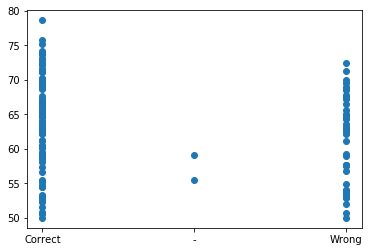

In [6]:
import nflgame
import pandas as pd
import glob
import os
import matplotlib.pylab as plt


pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999

year = 2018

directory = './predictions/{}/'.format(year)
all_files = glob.glob(directory + '*.csv')

predictions_df = pd.concat((pd.read_csv(f) for f in all_files),
                           axis=0, sort=False, ignore_index=True)

success_counter = len(predictions_df.loc[predictions_df['success'] == 'Correct'])
game_count = len(predictions_df['game'])
success_pct = round((float(success_counter)/game_count)*100, 2)
print predictions_df
print '{}/{} {}%'.format(success_counter, game_count, success_pct)

plt.scatter(predictions_df['success'], predictions_df['prediction_probability'])
plt.show()